In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Data Augmentation & Transformation

In [2]:
#Random Crop, Horizontal flip, Rotation, Normalisation on train data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Normalisation on test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Loading the dataset into Dataloaders

In [3]:
#Loading test and train data with batch size 128
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Basic Architecture

In [4]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        # Initialize independent convolutional layers with the same input and output dimensions
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_layers)])
        
        # Fully connected layer to compute the weights 'a' for combining the outputs of the convolutional layers
        self.fc = nn.Linear(in_channels, num_layers)
        
    def forward(self, x):
        # Perform global average pooling to compute the average value of each channel 
        avg_pool = torch.mean(x, dim=[2, 3])
        
        # Compute the weights 'a' for each convolutional layer's output, ensuring they are between 0 and 1
        a = torch.sigmoid(self.fc(avg_pool))
        
        # Apply each convolutional layer to the input x and accumulate the weighted sum
        weighted_sum = torch.zeros_like(x)
        for i, conv in enumerate(self.convs):
            conv_out = conv(x)
            weighted_sum += a[:, i:i+1, None, None] * conv_out
        # Apply ReLU activation function to the combined output
        out = F.relu(weighted_sum)
        return out

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        
        # Fully connected layer to map the pooled features to the number of classes
        self.fc = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        
        # Apply global average pooling to calculate the channel's average value
        x = torch.mean(x, dim=[2, 3])
        
        # Pass the pooled features through the fully connected layer to get the class logits
        x = self.fc(x)

        return x

class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        # Initialize the first intermediate block with 3 input channels, 64 output channels, and 3 number of layers
        self.block1 = IntermediateBlock(3, 64, 3)
       
        # Initialize the second intermediate block with 64 input channels, 128 output channels, and 3 number of layers
        self.block2 = IntermediateBlock(64, 128, 3)
        
        # Initialize the output block to produce final class logits with 128 input channels and 10 output classes
        self.output_block = OutputBlock(128, 10)

    def forward(self, x):
        # Pass the input through the blocks
        x = self.block1(x)
        x = self.block2(x)
        
        # Pass the final output through the output block to get class logits
        x = self.output_block(x)
        return x

### Improved Neural Network based on the given architecture

In [5]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, dropout_rate=0.1):
        super(IntermediateBlock, self).__init__()
        
        #Initialize independent convolutional layers with the same input and output dimensions
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_layers)])
        
        #Apply batch normalization to the output of each convolutional layer
        self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) for _ in range(num_layers)])
        
        #Initialize dropout to reduce overfitting
        self.dropout = nn.Dropout(dropout_rate)
        
        #Fully connected layer to compute the weights 'a' for combining the outputs of the convolutional layers
        self.fc = nn.Linear(in_channels, num_layers)
        
    def forward(self, x):
        #Perform global average pooling to compute average value of each channel 
        avg_pool = torch.mean(x, dim=[2, 3])
        
        #Compute the weights 'a' for each convolutional layer's output, ensuring they are between 0 and 1
        a = torch.sigmoid(self.fc(avg_pool))
        
        # Initialize the weighted sum of convolutional outputs to zero
        weighted_sum = 0
        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
            #Apply convolution followed by batch normalization
            conv_out = bn(conv(x))
            
            #Add to the weighted sum, with weights 'a' applied to each convolutional layer's output
            weighted_sum += a[:, i:i+1, None, None] * conv_out
        
        #Apply dropout and ReLU activation function to the combined output
        out = self.dropout(F.relu(weighted_sum))
        
        return out

class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        
        #Fully connected layer to map the pooled features to the number of classes
        self.fc = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        #Apply global average pooling to calculate channel's average value
        x = torch.mean(x, dim=[2, 3])
        
        #Pass the pooled features through the fully connected layer to get the class logits
        x = self.fc(x)
        
        return x

class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        #Initialize the first intermediate block with 3 input channels, 64 output channels, and 3 number of layers
        self.block1 = IntermediateBlock(3, 64, 3)
        
        #Apply max pooling to reduce spatial dimensions after block 1
        self.pool1 = nn.MaxPool2d(2, 2)
        
        #Initialize the second intermediate block
        self.block2 = IntermediateBlock(64, 128, 3)
        
        #Apply max pooling after block 2
        self.pool2 = nn.MaxPool2d(2, 2)
        
        #Initialize the third intermediate block
        self.block3 = IntermediateBlock(128, 256, 3)
        
        #Apply max pooling after block 3
        self.pool3 = nn.MaxPool2d(2, 2)
        
        #Initialize the output block to produce final class logits
        self.output_block = OutputBlock(256, 10)

    def forward(self, x):
        #Pass the input through the blocks and pooling layers
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        x = self.block3(x)
        x = self.pool3(x)
        
        #Pass the final output through the output block to get class logits
        x = self.output_block(x)
        
        return x

### Training the neural network

In [6]:
#Lists to store the loss, training and testing accuracies
batch_losses = []  
epoch_train_accuracies = []  
epoch_test_accuracies = []  

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50):
    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0 
        correct, total = 0, 0

        # Iterate over the training data.
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device) 
            optimizer.zero_grad()  
            
            outputs = model(images)  #Forward pass: compute the model output given images.
            loss = criterion(outputs, labels)  # Calculate the loss between the model output and true labels.
            loss.backward()  #Backward pass: compute gradient of the loss with respect to model parameters.
            optimizer.step()  #Optimize: update the model parameters based on the gradient.

            running_loss += loss.item() 
            batch_losses.append(loss.item()) 

            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()
        
        #Calculate training accuracy for the epoch.
        epoch_train_accuracy = 100 * correct / total
        epoch_train_accuracies.append(epoch_train_accuracy)

        # Evaluate the model on the test set.
        model.eval() 
        test_loss = 0.0  
        correct_test, total_test = 0, 0  
        with torch.no_grad():  
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device) 
                outputs = model(images)  
                loss = criterion(outputs, labels)  
                test_loss += loss.item()  
                _, predicted = torch.max(outputs.data, 1)  
                total_test += labels.size(0)  
                correct_test += (predicted == labels).sum().item()  

        #Calculate test accuracy for the epoch
        epoch_test_accuracy = 100 * correct_test / total_test
        epoch_test_accuracies.append(epoch_test_accuracy)  

        #Calculate the average test loss
        test_loss /= len(test_loader)  
        
        #Adjust the learning rate based on the test loss.
        scheduler.step(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train accuracy: {epoch_train_accuracy:.2f}%, "
              f"Test accuracy: {epoch_test_accuracy:.2f}%, "
              f"LR: {optimizer.param_groups[0]['lr']}")


In [7]:
#Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=50)

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/50], Loss: 1.4486, Train accuracy: 47.15%, Test accuracy: 35.55%, LR: 0.001
Epoch [2/50], Loss: 1.1644, Train accuracy: 58.46%, Test accuracy: 59.67%, LR: 0.001
Epoch [3/50], Loss: 1.0516, Train accuracy: 62.61%, Test accuracy: 55.80%, LR: 0.001
Epoch [4/50], Loss: 0.9740, Train accuracy: 65.55%, Test accuracy: 59.90%, LR: 0.001
Epoch [5/50], Loss: 0.9123, Train accuracy: 67.76%, Test accuracy: 64.10%, LR: 0.001
Epoch [6/50], Loss: 0.8606, Train accuracy: 69.49%, Test accuracy: 66.33%, LR: 0.001
Epoch [7/50], Loss: 0.8197, Train accuracy: 71.33%, Test accuracy: 66.79%, LR: 0.001
Epoch [8/50], Loss: 0.7814, Train accuracy: 72.50%, Test accuracy: 61.69%, LR: 0.001
Epoch [9/50], Loss: 0.7543, Train accuracy: 73.48%, Test accuracy: 74.17%, LR: 0.001
Epoch [10/50], Loss: 0.7201, Train accuracy: 74.79%, Test accuracy: 64.84%, LR: 0.001
Epoch [11/50], Loss: 0.6942, Train accuracy: 75.48%, Test accuracy: 74.82%, LR: 0.001
Epoch [12/50], Loss: 0.6740, Train accuracy: 76.38%, Test accur

### Plotting results

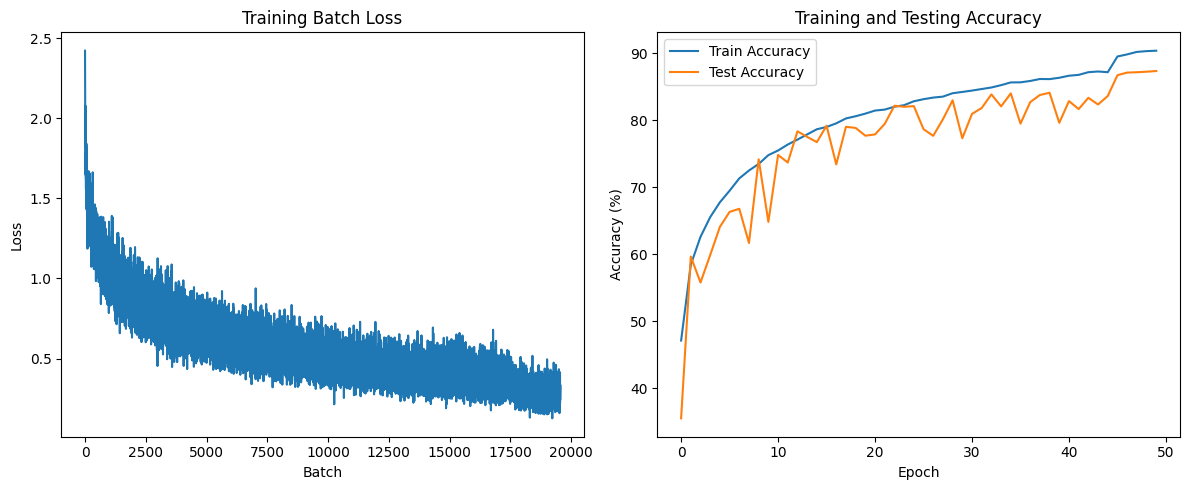

In [8]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label='Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Batch Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_train_accuracies, label='Train Accuracy')
plt.plot(epoch_test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### References

- Amirian, Mohammadreza & Schwenker, Friedhelm. (2020). Radial Basis Function Networks for Convolutional Neural Networks to Learn Similarity Distance Metric and Improve Interpretability. IEEE Access. PP. 1-1. 10.1109/ACCESS.2020.3007337. 